In [29]:
import pandas as pd
from matplotlib import pyplot as plt
from pipeline.acquisition import load_sisfall_data
from pipeline.preprocessing import change_activity_duration
from pipeline.preprocessing import change_activity_sampling
from pipeline.feature_extraction import extract_features
import joblib
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from sklearn import preprocessing
from sklearn.feature_selection import SelectFromModel

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

In [30]:
dataset_folder = "datasets/SisFall_dataset/"
models_output_folder = 'models/'
uma_dataset_folder = "datasets/output_uma"
combined_dataset_folder = "datasets/combined_dataset"


INCLUDE_GYROSCOPE = False

if INCLUDE_GYROSCOPE:
    sensors =  [0, 1, 2, 3, 4, 5]
else:
    sensors = [0, 1, 2]

should_load_sisfall_data = False

ignored_subjects = []
duration = 12000
frequency = 200

should_save_models = True

In [31]:
if should_load_sisfall_data is True:
    raw_sisfall_dataset = load_sisfall_data(dataset_folder, ignored_subjects, sensors)

    raw_sisfall_dataset.to_pickle(f"{combined_dataset_folder}/sisfall_raw_dataset.pkl")
else:
    raw_sisfall_dataset = pd.read_pickle(f"{combined_dataset_folder}/sisfall_raw_dataset.pkl")

In [32]:
raw_sisfall_dataset['data'][0]

,acc_x,acc_y,acc_z
2000-01-01 00:00:05.000,-0.003906,-0.886719,-0.421875
2000-01-01 00:00:05.005,-0.019531,-0.859375,-0.398438
2000-01-01 00:00:05.010,-0.046875,-0.820312,-0.390625
2000-01-01 00:00:05.015,-0.062500,-0.808594,-0.386719
2000-01-01 00:00:05.020,-0.082031,-0.824219,-0.351562
...,...,...,...
2000-01-01 00:00:14.975,0.027344,-0.953125,0.121094
2000-01-01 00:00:14.980,0.042969,-0.968750,0.113281
2000-01-01 00:00:14.985,0.042969,-0.968750,0.105469
2000-01-01 00:00:14.990,0.035156,-0.968750,0.121094


In [33]:
import os
import re

def uma_search_csv_files(directory, activities_of_interest=None):
    csv_files = []
    for current_folder, _, files in os.walk(directory):
        for file in files:
            if file.endswith('.csv'):
                if activities_of_interest is not None:
                    for activity in activities_of_interest:
                        # Use regex to match exact activity number
                        pattern = rf"{activity}(?=Trial|_|\.csv)"
                        if re.search(pattern, file):
                            full_path = os.path.join(current_folder, file)
                            csv_files.append(full_path)
                            break
                else:
                    full_path = os.path.join(current_folder, file)
                    csv_files.append(full_path)
    return csv_files


uma_files = uma_search_csv_files(directory=uma_dataset_folder, activities_of_interest=['Activity1','Activity2','Activity4','Activity5','Activity6','Activity7','Activity8','Activity9','Activity10','Activity11','Activity12','Activity13','Activity14','Activity15'])

combined_uma_df = pd.concat([pd.read_csv(file) for file in uma_files], ignore_index=True)

combined_uma_df.rename(columns={
    'Accelerometer: x-axis (g)': 'acc_x',
    'Accelerometer: y-axis (g)': 'acc_y',
    'Accelerometer: z-axis (g)': 'acc_z',
    'Gyroscope: x-axis (rad/s)': 'gyro_x',
    'Gyroscope: y-axis (rad/s)': 'gyro_y',
    'Gyroscope: z-axis (rad/s)': 'gyro_z'
}, inplace=True)

# Display the shape of the combined dataframe
combined_uma_df[700:710]

,TimeStamp,acc_x,acc_y,acc_z,Subject,Activity,Trial,Tag
700,7.337,0.133057,0.416016,0.91748,15,14,3,0
701,7.343,0.14209,0.4104,0.921387,15,14,3,0
702,7.348,0.14209,0.4104,0.921387,15,14,3,0
703,7.383,0.137695,0.414551,0.915039,15,14,3,0
704,7.432,0.132812,0.406738,0.918213,15,14,3,0
705,7.578,0.140869,0.412842,0.91626,15,14,3,0
706,7.581,0.140869,0.412842,0.91626,15,14,3,0
707,7.627,0.144775,0.407715,0.921875,15,14,3,0
708,7.630,0.140381,0.468262,0.91748,15,14,3,0
709,7.773,0.138184,0.46582,0.918457,15,14,3,0


In [34]:
UMA_ACTIVITY_MAPPING = {
    'D1': 'adl',
    'D2': 'adl',
    'D3': 'adl',
    'D4': 'adl',
    'D5': 'adl',
    'D6': 'adl',
    'D7': 'adl',
    'D8': 'adl',
    'D9': 'adl',
    'D10': 'adl',
    'D11': 'adl',
    'D12': 'adl',
    'D13': 'fall',
    'D14': 'fall',
    'D15': 'fall'
}

grouped_data = []

# Sort by Subject, Activity, Trial, and TimeStamp to ensure proper ordering
combined_df_sorted = combined_uma_df.sort_values(['Subject', 'Activity', 'Trial', 'TimeStamp']).reset_index(drop=True)

current_group = []
current_subject = None
current_activity = None
current_trial = None
group_id = 0

for idx, row in combined_df_sorted.iterrows():
    # Check if we're starting a new session (different subject/activity/trial)
    if (current_subject != row['Subject'] or 
        current_activity != row['Activity'] or 
        current_trial != row['Trial']):
        
        # Save the previous group if it exists
        if current_group:
            group_df = pd.DataFrame(current_group)

            if INCLUDE_GYROSCOPE:
                sensor_data = group_df[['acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z']]
            else:
                sensor_data = group_df[['acc_x', 'acc_y', 'acc_z']]

            timestamps = group_df['TimeStamp']
            
            group_row = {
                'subject': current_subject,
                'activity': f"D{current_activity}",
                'trial': current_trial,
                # 'group_id': group_id,
                'data': sensor_data,
            }
            grouped_data.append(group_row)
            group_id += 1
        
        # Start new group
        current_group = [row.to_dict()]
        current_subject = row['Subject']
        current_activity = row['Activity']
        current_trial = row['Trial']
    else:
        # Check if timestamp has reset/jumped backwards (indicating new data segment)
        if current_group:
            last_timestamp = current_group[-1]['TimeStamp']
            current_timestamp = row['TimeStamp']
            
            # If current timestamp is less than or equal to previous (reset occurred)
            if current_timestamp <= last_timestamp:
                # Save the current group
                group_df = pd.DataFrame(current_group)
                if INCLUDE_GYROSCOPE:
                    sensor_data = group_df[['acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z']]
                else:   
                    sensor_data = group_df[['acc_x', 'acc_y', 'acc_z']]
                timestamps = group_df['TimeStamp']
                
                group_row = {
                    'subject': current_subject,
                    'activity': f"D{current_activity}",
                    'trial': current_trial,
                    'data': sensor_data,
                }
                grouped_data.append(group_row)
                group_id += 1
                
                # Start new group with current row
                current_group = [row.to_dict()]
            else:
                # Continue adding to current group
                current_group.append(row.to_dict())
        else:
            current_group.append(row.to_dict())

# Don't forget the last group
if current_group:
    group_df = pd.DataFrame(current_group)
    if INCLUDE_GYROSCOPE:
        sensor_data = group_df[['acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z']]
    else:
        sensor_data = group_df[['acc_x', 'acc_y', 'acc_z']]
    timestamps = group_df['TimeStamp']
    
    group_row = {
        'subject': current_subject,
        'activity': f"D{current_activity}",
        'trial': current_trial,
        'data': sensor_data,
    }
    grouped_data.append(group_row)

# Convert to DataFrame
uma_raw_dataset = pd.DataFrame(grouped_data)
uma_raw_dataset


,subject,activity,trial,data
0,1,D1,1,acc_x acc_y acc_z 0 -0.74023...
1,1,D1,2,acc_x acc_y acc_z 0 -0.76416...
2,1,D1,3,acc_x acc_y acc_z 0 -0.75732...
3,1,D8,1,acc_x acc_y acc_z 0 -0.58740...
4,1,D8,2,acc_x acc_y acc_z 0 -0.81396...
...,...,...,...,...
622,19,D15,2,acc_x acc_y acc_z 0 -1.02294...
623,19,D15,3,acc_x acc_y acc_z 0 -1.37255...
624,19,D15,4,acc_x acc_y acc_z 0 -0.92089...
625,19,D15,5,acc_x acc_y acc_z 0 -0.90795...


In [35]:
import itertools
import numpy as np


def extract_features(data, with_magnitude):
    """
    Extracts various features from the time and frequency domains from a given sample of activity. Also constructs
    features by combining the raw data.

    :param data: the data from the activity
    :param with_magnitude: calculate the magnitude of the sensors
    :return: list with all the features extracted from the activity
    """
    
    # Make a copy to avoid modifying original data
    data = data.copy()
    
    # Clean and ensure all data is numeric
    for col in data.columns:
        # Convert to string first, then replace any concatenated values
        data[col] = data[col].astype(str)
        # If values are concatenated, this won't work well, so let's handle it
        data[col] = pd.to_numeric(data[col], errors='coerce')
    
    # Fill any NaN values with 0
    data = data.fillna(0)
    
    # Check if we still have any non-numeric data
    if not data.select_dtypes(include=[np.number]).shape[1] == data.shape[1]:
        print("Warning: Non-numeric data detected, attempting to clean...")
        # Additional cleaning if needed
        for col in data.columns:
            if data[col].dtype == 'object':
                print(f"Column {col} contains non-numeric data")
                data[col] = 0  # Set problematic columns to 0
    
    # Calculates the acceleration and rotation magnitudes
    if with_magnitude:
        for i in range(0, data.shape[1], 3):
            if i + 2 < data.shape[1]:  # Ensure we have 3 columns
                # Select the 3-axis slice
                slice_ = data.iloc[:, i:i+3]
                
                # Compute magnitude
                magnitude = np.linalg.norm(slice_, axis=1)
                
                # Generate magnitude column name
                name = 'mag_' + data.columns[i][0:len(data.columns[i])-2]
                
                # Assign magnitude column
                data[name] = magnitude

    # Creates features vector name
    names = ['mean', 'var', 'std', 'median', 'max', 'min', 'ptp', 'centile25', 'centile75']
    columns = list('_'.join(n) for n in itertools.product(names, data.columns.tolist()))

    # Time domain features
    features = np.mean(data, axis=0)
    features = np.hstack((features, np.var(data, axis=0)))
    features = np.hstack((features, np.std(data, axis=0)))
    features = np.hstack((features, np.median(data, axis=0)))
    features = np.hstack((features, np.max(data, axis=0)))
    features = np.hstack((features, np.min(data, axis=0)))
    features = np.hstack((features, np.ptp(np.asarray(data), axis=0)))
    features = np.hstack((features, np.percentile(data, 25, axis=0)))
    features = np.hstack((features, np.percentile(data, 75, axis=0)))

    # Creates a DataFrame
    features = pd.DataFrame([features], columns=columns)
    return features

# Extract features from uma_dataset
print("Processing UMA dataset...")
feature_list = []
labels = []
subjects = []
activity_codes = []

for i in uma_raw_dataset.index:
    # Get data from each row
    data = uma_raw_dataset['data'][i]
    
    # Extract features
    features_uma = extract_features(data, True)
    
    # Store results
    feature_list.append(features_uma)
    subjects.append(uma_raw_dataset['subject'][i])
    activity_codes.append(uma_raw_dataset['activity'][i])

# Combine into final dataset
uma_raw_dataset = pd.concat(feature_list, ignore_index=True)
uma_raw_dataset['subject'] = subjects
uma_raw_dataset['activity_code'] = activity_codes




ALL_ACTIVITY_MAPPING = {
    'D01': 'adl',
    'D02': 'adl',
    'D03': 'adl',
    'D04': 'adl',
    'D05': 'adl',
    'D06': 'adl',
    'D07': 'adl',
    'D08': 'adl',
    'D09': 'adl',
    'D10': 'adl',
    'D11': 'adl',
    'D12': 'adl',
    'D13': 'fall',
    'D14': 'fall',
    'D15': 'fall',
    'D16': 'adl',
    'D17': 'adl',
    'D18': 'adl',
    'D19': 'adl',
    'F01': 'fall',
    'F02': 'fall',
    'F03': 'fall',
    'F04': 'fall',
    'F05': 'fall',
    'F06': 'fall',
    'F07': 'fall',
    'F08': 'fall',
    'F09': 'fall',
    'F10': 'fall',
    'F11': 'fall',
    'F12': 'fall',
    'F13': 'fall',
    'F14': 'fall',
    'F15': 'fall',
    'D1': 'adl',
    'D8': 'adl',
    'D9': 'adl',
    'D2': 'adl',
    'D4': 'adl',
    'D7': 'adl',
    'D5': 'adl',
    'D6': 'adl'
}

activity_codes = uma_raw_dataset['activity_code'] 
y_labels = activity_codes.map(ALL_ACTIVITY_MAPPING)

y_labels
# X_uma = uma_raw_dataset.drop(columns=['activity_code', 'subject'])
# X_uma


Processing UMA dataset...


0       adl
1       adl
2       adl
3       adl
4       adl
       ... 
622    fall
623    fall
624    fall
625    fall
626    fall
Name: activity_code, Length: 627, dtype: object

In [36]:
ACTIVITY_CLASSES = {
    'adl': ['D01', 'D02','D03', 'D04', 'D05', 'D06', 'D07', 'D08', 'D09', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'D16', 'D17', 'D18', 'D19'],
    'fall': ['F01', 'F02', 'F03', 'F04', 'F05', 'F06', 'F07', 'F08', 'F09', 'F10', "F11","F12","F13", "F14","F15"],
}

# Create code to class mapping
CODE_TO_CLASS = {}
for class_name, codes in ACTIVITY_CLASSES.items():
    for code in codes:
        CODE_TO_CLASS[code] = class_name


    
def prepare_sisfall_dataset(raw_dataset, CODE_TO_CLASS, duration, frequency):
    """
    Prepare dataset by filtering activities, extracting features, and organizing data.
    
    Parameters:
    raw_dataset: Raw dataset containing 'activity', 'data', and 'subject' columns
    CODE_TO_CLASS: Dictionary mapping activity codes to class labels
    duration: Duration parameter for activity processing
    frequency: Frequency parameter for activity sampling
    
    Returns:
    pd.DataFrame: Prepared dataset with features, class labels, subjects, and activity codes
    """
    
    # Filter indices based on activity codes
    filtered_indices = []
    for i in raw_dataset.index:
        activity_code = raw_dataset['activity'][i]
        if activity_code in CODE_TO_CLASS:
            filtered_indices.append(i)

    
    feature_list = []
    labels = []
    subjects = []
    activity_codes = []

    for i in filtered_indices:

        # Get data and preprocess
        data = raw_dataset['data'][i]
        print(data.shape,'before')
        data = change_activity_duration(data, duration)
        print(data.shape,'after')

        data = change_activity_sampling(data, frequency)
        
        # Extract features
        features = extract_features(data, True)
        
        # Get class label
        activity_code = raw_dataset['activity'][i]
        class_label = CODE_TO_CLASS[activity_code]
        
        # Store results
        feature_list.append(features)
        labels.append(class_label)
        subjects.append(raw_dataset['subject'][i])
        activity_codes.append(activity_code)

    # Combine into final dataset
    prepared_dataset = pd.concat(feature_list, ignore_index=True)
    prepared_dataset['class'] = labels
    prepared_dataset['subject'] = subjects
    prepared_dataset['activity_code'] = activity_codes

    print(f"Final dataset shape: {prepared_dataset.shape}")
    print("\nClass distribution:")
    print(prepared_dataset['class'].value_counts())
    
    return prepared_dataset

# prepared_dataset = prepare_dataset(raw_sisfall_dataset, CODE_TO_CLASS, duration, frequency)
prepared_dataset = prepare_sisfall_dataset(raw_sisfall_dataset, CODE_TO_CLASS, duration, frequency)

(2000, 3) before
(200, 3) after
(2000, 3) before
(200, 3) after
(2000, 3) before
(200, 3) after
(2000, 3) before
(200, 3) after
(2000, 3) before
(200, 3) after
(2000, 3) before
(200, 3) after
(2000, 3) before
(200, 3) after
(2000, 3) before
(200, 3) after
(2000, 3) before
(200, 3) after
(2000, 3) before
(200, 3) after
(2000, 3) before
(200, 3) after
(2000, 3) before
(200, 3) after
(2000, 3) before
(200, 3) after
(2000, 3) before
(200, 3) after
(2000, 3) before
(200, 3) after
(2000, 3) before
(200, 3) after
(2000, 3) before
(200, 3) after
(2000, 3) before
(200, 3) after
(2000, 3) before
(200, 3) after
(2000, 3) before
(200, 3) after
(5000, 3) before
(2400, 3) after
(5000, 3) before
(2400, 3) after
(5000, 3) before
(2400, 3) after
(5000, 3) before
(2400, 3) after
(5000, 3) before
(2400, 3) after
(5000, 3) before
(2400, 3) after
(5000, 3) before
(2400, 3) after
(5000, 3) before
(2400, 3) after
(5000, 3) before
(2400, 3) after
(5000, 3) before
(2400, 3) after
(2400, 3) before
(2400, 3) aft

In [37]:
prepared_dataset.drop(columns=['activity_code','subject'], inplace=True)

In [38]:
uma_raw_dataset['class'] = uma_raw_dataset['activity_code'].map(ALL_ACTIVITY_MAPPING)
uma_raw_dataset.drop(columns=['activity_code', 'subject'], inplace=True)

In [39]:
prepared_dataset

,mean_acc_x,mean_acc_y,mean_acc_z,mean_mag_acc,var_acc_x,var_acc_y,var_acc_z,var_mag_acc,std_acc_x,std_acc_y,...,ptp_mag_acc,centile25_acc_x,centile25_acc_y,centile25_acc_z,centile25_mag_acc,centile75_acc_x,centile75_acc_y,centile75_acc_z,centile75_mag_acc,class
0,0.008047,-1.002363,-0.116230,1.027459,0.014411,0.024467,0.022692,0.024205,0.120046,0.156419,...,0.716120,-0.058594,-1.093750,-0.207031,0.912239,0.074219,-0.894531,-0.003906,1.112180,adl
1,0.032422,-1.010781,-0.153926,1.047548,0.013144,0.046032,0.032962,0.041203,0.114648,0.214550,...,0.874586,-0.043945,-1.148438,-0.242188,0.890982,0.071289,-0.862305,-0.041992,1.162675,adl
2,0.086914,-0.996895,-0.131387,1.036573,0.018921,0.049386,0.031944,0.044382,0.137555,0.222231,...,0.997805,0.034180,-1.070312,-0.223633,0.902399,0.137695,-0.880859,-0.012695,1.122104,adl
3,0.071191,-0.990645,-0.109707,1.027136,0.020926,0.052222,0.032249,0.048870,0.144657,0.228522,...,0.948117,0.000000,-1.055664,-0.184570,0.866589,0.122070,-0.842773,-0.006836,1.124120,adl
4,0.019824,-1.038809,-0.144199,1.083208,0.024211,0.066873,0.043796,0.061850,0.155598,0.258598,...,1.067569,-0.114258,-1.180664,-0.247070,0.909638,0.127930,-0.870117,-0.035156,1.203087,adl
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5100,0.003481,-0.868242,-0.343172,1.003846,0.058301,0.018607,0.061480,0.002305,0.241457,0.136407,...,0.442335,-0.188477,-0.984375,-0.535156,0.986576,0.148438,-0.769531,-0.085938,1.019737,adl
5101,0.076816,-0.890903,-0.265866,1.003875,0.057662,0.017463,0.064183,0.001836,0.240128,0.132148,...,0.470503,0.113281,-0.980469,-0.484375,0.992606,0.191406,-0.816406,-0.062500,1.011398,adl
5102,-0.048776,-0.919728,-0.203848,1.004807,0.036690,0.017906,0.066739,0.001531,0.191548,0.133812,...,0.470020,-0.074219,-1.000000,-0.375000,0.993699,0.003906,-0.863281,-0.019531,1.016017,adl
5103,0.013631,-0.886082,-0.264712,1.004711,0.054687,0.020477,0.081273,0.002392,0.233853,0.143096,...,0.513299,-0.101562,-0.996094,-0.507812,0.988609,0.101562,-0.753906,-0.031250,1.016284,adl


In [40]:
final_combined_dataset = pd.concat([prepared_dataset, uma_raw_dataset], ignore_index=True)

In [41]:
final_combined_dataset

,mean_acc_x,mean_acc_y,mean_acc_z,mean_mag_acc,var_acc_x,var_acc_y,var_acc_z,var_mag_acc,std_acc_x,std_acc_y,...,ptp_mag_acc,centile25_acc_x,centile25_acc_y,centile25_acc_z,centile25_mag_acc,centile75_acc_x,centile75_acc_y,centile75_acc_z,centile75_mag_acc,class
0,0.008047,-1.002363,-0.116230,1.027459,0.014411,0.024467,0.022692,0.024205,0.120046,0.156419,...,0.716120,-0.058594,-1.093750,-0.207031,0.912239,0.074219,-0.894531,-0.003906,1.112180,adl
1,0.032422,-1.010781,-0.153926,1.047548,0.013144,0.046032,0.032962,0.041203,0.114648,0.214550,...,0.874586,-0.043945,-1.148438,-0.242188,0.890982,0.071289,-0.862305,-0.041992,1.162675,adl
2,0.086914,-0.996895,-0.131387,1.036573,0.018921,0.049386,0.031944,0.044382,0.137555,0.222231,...,0.997805,0.034180,-1.070312,-0.223633,0.902399,0.137695,-0.880859,-0.012695,1.122104,adl
3,0.071191,-0.990645,-0.109707,1.027136,0.020926,0.052222,0.032249,0.048870,0.144657,0.228522,...,0.948117,0.000000,-1.055664,-0.184570,0.866589,0.122070,-0.842773,-0.006836,1.124120,adl
4,0.019824,-1.038809,-0.144199,1.083208,0.024211,0.066873,0.043796,0.061850,0.155598,0.258598,...,1.067569,-0.114258,-1.180664,-0.247070,0.909638,0.127930,-0.870117,-0.035156,1.203087,adl
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5727,-0.198070,0.358674,0.618709,1.052136,0.152059,0.229037,0.209130,0.033916,0.389947,0.478578,...,2.061288,-0.272461,-0.112061,0.579102,0.971959,-0.060791,0.700684,0.864258,1.090969,fall
5728,-0.144246,0.619491,-0.081711,1.126797,0.184675,1.139300,0.496442,0.961999,0.429738,1.067380,...,9.651395,-0.020020,0.783691,-0.081299,0.935022,-0.008301,0.937256,0.035400,1.004671,fall
5729,-0.619123,-0.596731,0.389268,1.068791,0.053604,0.128418,0.136904,0.067544,0.231526,0.358355,...,3.522952,-0.708740,-0.774841,0.178711,0.986254,-0.533203,-0.464844,0.564209,1.084290,fall
5730,-0.144801,0.470989,-0.601326,0.959936,0.084430,0.114638,0.153182,0.035164,0.290569,0.338582,...,2.171418,-0.089111,0.479614,-0.769409,0.905493,-0.045898,0.631104,-0.670776,0.959350,fall


In [42]:
from sklearn.model_selection import train_test_split


X_train,X_test = train_test_split(final_combined_dataset, 
    test_size=0.2, 
    stratify=final_combined_dataset['class'], 
    random_state=42
)

y_train = X_train['class']
y_test = X_test['class']

final_X_train = X_train.drop(columns=['class'])
final_X_test = X_test.drop(columns=['class'])



In [43]:
svm = SVC(kernel='rbf', C=10, gamma='scale', probability=True, random_state=42)
svm.fit(final_X_train, y_train)

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(final_X_train, y_train)

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(final_X_train, y_train)

dt = DecisionTreeClassifier(random_state=42)
dt.fit(final_X_train, y_train)


lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(final_X_train, y_train)


if should_save_models:
    joblib.dump(svm, f"{models_output_folder}/svm_model_combined_binary.pkl")
    joblib.dump(rf, f"{models_output_folder}/rf_model_combined_binary.pkl")
    joblib.dump(knn, f"{models_output_folder}/knn_model_combined_binary.pkl")
    joblib.dump(dt, f"{models_output_folder}/dt_model_combined_binary.pkl")
    joblib.dump(lr, f"{models_output_folder}/lr_model_combined_binary.pkl")


Model: SVC
Classification Report:
              precision    recall  f1-score   support

         adl       0.98      0.99      0.98       748
        fall       0.97      0.96      0.97       399

    accuracy                           0.98      1147
   macro avg       0.98      0.98      0.98      1147
weighted avg       0.98      0.98      0.98      1147

Confusion Matrix:
Accuracy: 0.9791



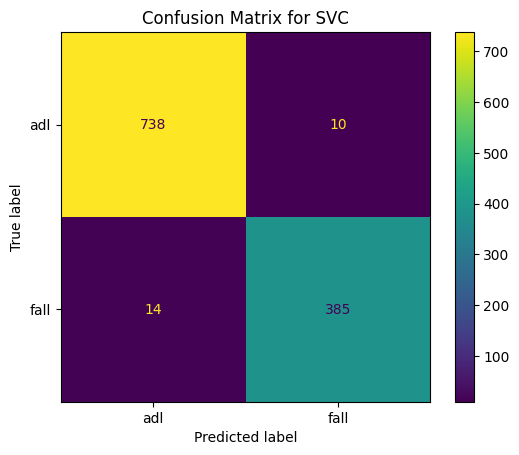

Model: RandomForestClassifier
Classification Report:
              precision    recall  f1-score   support

         adl       0.99      0.99      0.99       748
        fall       0.99      0.98      0.98       399

    accuracy                           0.99      1147
   macro avg       0.99      0.99      0.99      1147
weighted avg       0.99      0.99      0.99      1147

Confusion Matrix:
Accuracy: 0.9887



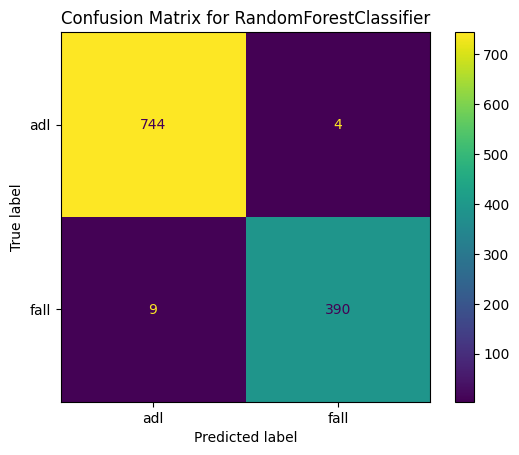

Model: KNeighborsClassifier
Classification Report:
              precision    recall  f1-score   support

         adl       0.98      0.97      0.98       748
        fall       0.95      0.97      0.96       399

    accuracy                           0.97      1147
   macro avg       0.97      0.97      0.97      1147
weighted avg       0.97      0.97      0.97      1147

Confusion Matrix:
Accuracy: 0.9704



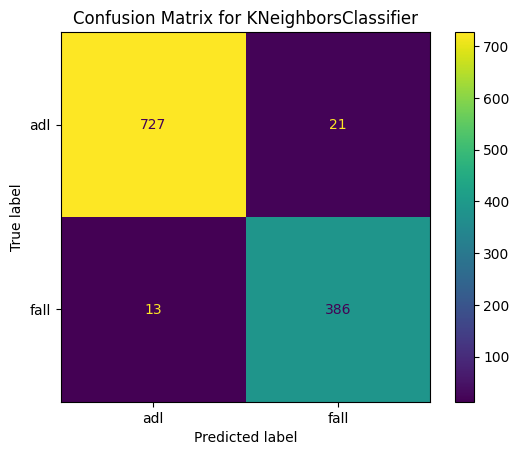

Model: DecisionTreeClassifier
Classification Report:
              precision    recall  f1-score   support

         adl       0.96      0.97      0.97       748
        fall       0.95      0.93      0.94       399

    accuracy                           0.96      1147
   macro avg       0.96      0.95      0.95      1147
weighted avg       0.96      0.96      0.96      1147

Confusion Matrix:
Accuracy: 0.9582



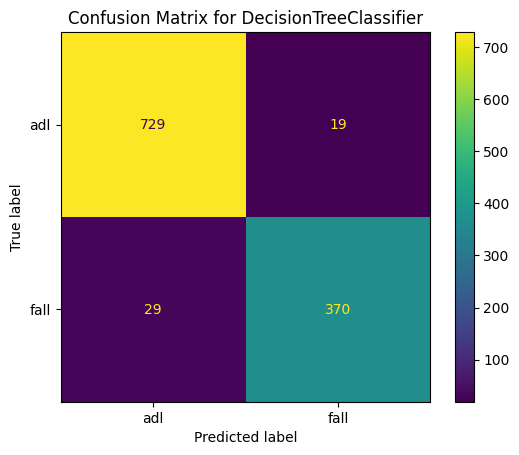

Model: LogisticRegression
Classification Report:
              precision    recall  f1-score   support

         adl       0.97      0.99      0.98       748
        fall       0.99      0.95      0.97       399

    accuracy                           0.98      1147
   macro avg       0.98      0.97      0.98      1147
weighted avg       0.98      0.98      0.98      1147

Confusion Matrix:
Accuracy: 0.9782



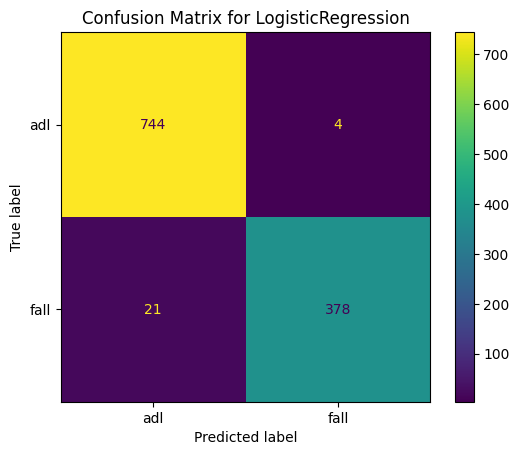

In [44]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    print(f"Model: {model.__class__.__name__}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:")
    cm = confusion_matrix(y_test, y_pred)
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}\n")
    
    # Plot confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(cmap='viridis')
    plt.title(f"Confusion Matrix for {model.__class__.__name__}")
    plt.show()

# Evaluate all models
evaluate_model(svm, final_X_test, y_test)
evaluate_model(rf, final_X_test, y_test)
evaluate_model(knn, final_X_test, y_test)
evaluate_model(dt, final_X_test, y_test)
evaluate_model(lr, final_X_test, y_test)